# KNOWLEDGE BASE APPROACH

In [1]:
import gym
import time
import matplotlib.pyplot as plt
from pyswip import Prolog
import IPython.display as display
from project_utils import *


## Basic Movement
For the first milestone of the project, we used the "Mapped" environment of Hide n' Seek-that is, a game mode in which the map is fully known since the beginning, therefore not needing exploration.
The first thing we did, after setting up the environment and finding out a way to formulate and update perceptions from the game into the knowledge base, was to design and test the basic movement towards the goal. Here's a test of the agent's movement in a fully mapped environment, with just trees.

Episode 0 - 12 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
After 1 episodes, mean return is 1.0
The rewards of the episodes are: [1.0]


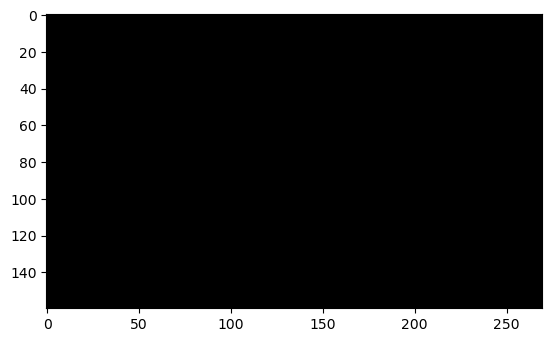

In [2]:

ENV = gym.make("MiniHack-Navigation-Custom-v0",des_file="dat/kb_movement.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))

evaluate(num_ep = 1, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "slow", show = True)

# Loops
Since the project's bigger picture would have included a heuristic pathfinding solution, we kept the reasoning "step-by-step" in the Knowledge Base version, without using lists to build a path before moving. For this reason, in this version of the system, loops might occur: it can be the case that the optimal path is blocked by trees or/and walls, and the agent walks back and forth over the same two cells even if these moves lead to a dead end. In the next map we can see an example of this behaviour.

Episode 0 - 6 steps
End status: RUNNING
Final reward: 0.0
After 1 episodes, mean return is 0.0
The rewards of the episodes are: [0.0]


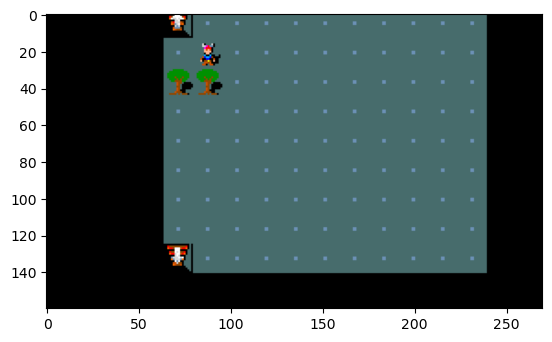

In [3]:
ENV = gym.make("MiniHack-Navigation-Custom-v0",des_file="dat/kb_loop.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 1, max_steps = 6, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "slow", show = True)

# Loop fix
To avoid the occurrence of loops, we "discouraged" the agent from walking over already-walked cells. 

Episode 0 - 9 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
After 1 episodes, mean return is 1.0
The rewards of the episodes are: [1.0]


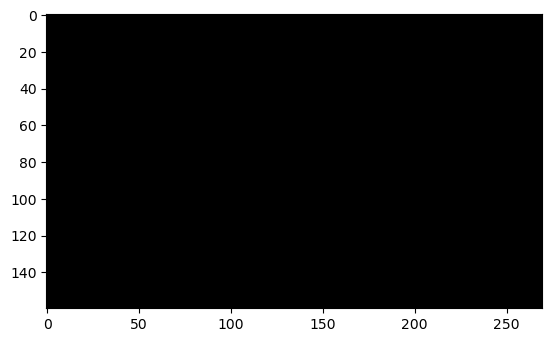

In [4]:
ENV = gym.make("MiniHack-Navigation-Custom-v0",des_file="dat/kb_loop.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 1, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "slow", show = True)

# Introducing monsters


Now it's time to bring the monsters in. In this version, the monsters are not considered by the agent at all: he just rushes towards the stairs, ignoring them. This didn't lead to horrible results though, since: 
- The agent has a leather armor, therefore it can often endure hits;
- Some monsters are slower than the agent, thus they occasionally skip turns;
- Many of the monsters have (powerful) ranged attacks;
- Some monsters have an ability called *infravision*, which means that they can locate the agent no matter the distance or obstacles;
- Clouds dont't seem effective to hide from the monster.

For these reasons, being exposed for a long time or avoiding close contact with the enemy can be counterproductive.  

KeyboardInterrupt: 

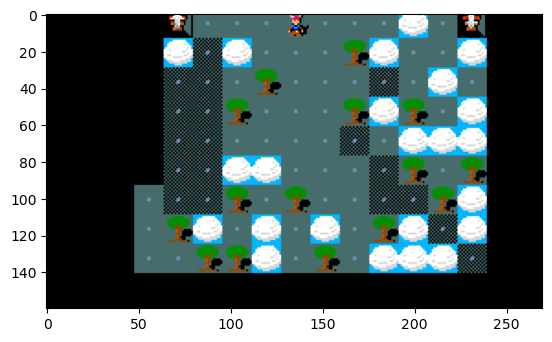

In [5]:
ENV = gym.make("MiniHack-HideNSeek-Mapped-v0",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 3, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "slow", show = True)

## Evaluation 
Now we look at some evaluation, with different monster pools:
- The **full HideNSeek pool** (Giant, Naga, Titan, Dragon, Ettin, Minotaur, Lich, Ogre, Troll);
- **Giant** only;
- **Naga** only.

The evaluation is ran over 500 episodes, with a maximum number of steps of 30, using the default Minihack Reward Manager, which yields a positive score of 1 for a successful episode, and 0 otherwise.  

In [6]:
ENV = gym.make("MiniHack-HideNSeek-Mapped-v0",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 500, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "fast", show = False)

#ADD GRAPH
#REMOVE IMPOSSIBLE TO PERFORM ANY ACTION

Episode 0 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 1 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 2 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 3 - 6 steps
End status: DEATH
Final reward: 0.0
Episode 4 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 5 - 30 steps
End status: RUNNING
Final reward: 0.0
Episode 6 - 8 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 7 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 8 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 9 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 10 - 8 steps
End status: DEATH
Final reward: 0.0
Episode 11 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 12 - 2 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 13 - 11 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 14 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 15 - 8 steps
E

KeyboardInterrupt: 

In [ ]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_N.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 500, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "fast", show = False)

#ADD GRAPH
#REMOVE IMPOSSIBLE TO PERFORM ANY ACTION

Episode 0 - 6 steps
End status: DEATH
Final reward: 0.0
Episode 1 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 2 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
ERROR: impossible to perform any action. Please check assertions and definitions in KB.
ERROR: impossible to perform any action. Please check assertions and definitions in KB.
ERROR: impossible to perform any action. Please check assertions and definitions in KB.
ERROR: impossible to perform any action. Please check assertions and definitions in KB.
ERROR: impossible to perform any action. Please check assertions and definitions in KB.
ERROR: impossible to perform any action. Please check assertions and definitions in KB.
ERROR: impossible to perform any action. Please check assertions and definitions in KB.
ERROR: impossible to perform any action. Please check assertions and definitions in KB.
ERROR: impossible to perform any action. Please check assertions and definitions in KB.
ERROR: impossible 

KeyboardInterrupt: 

In [ ]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_H.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 500, max_steps = 30, kb_path = 'kbs/looping_kb.pl', env = ENV, speed = "fast", show = False)

#ADD GRAPH
#REMOVE IMPOSSIBLE TO PERFORM ANY ACTION

Episode 0 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 1 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 2 - 8 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 3 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 4 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 5 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0
Episode 6 - 8 steps
End status: TASK_SUCCESSFUL
Final reward: 1.0


KeyboardInterrupt: 

# Final improvements: dealing with monsters
Though not catastrophic, the strategy of completely ignoring the monster isn't enough, especially against the **Naga**. She rocks a powerful fire ranged attack, whilst having the same speed as the agent. Since enemies can attack us at range from basically *any* distance, performing intricated movement strategies would both put us at risk of exceeding the maximum number of steps and give the monster more attempts to hit us at range. One useful thing, though, is that ranged attacks seem to have a *lower* chance to connect if the line of fire is not exactly *perpendicular* (or *diagonal*). Thus, we made the agent less prone to walk in those cells, as well as the cells strictly adjacent to the monster. Also, the agent keeps tracks of the last enemy position, when it disappears into clouds.


KeyboardInterrupt: 

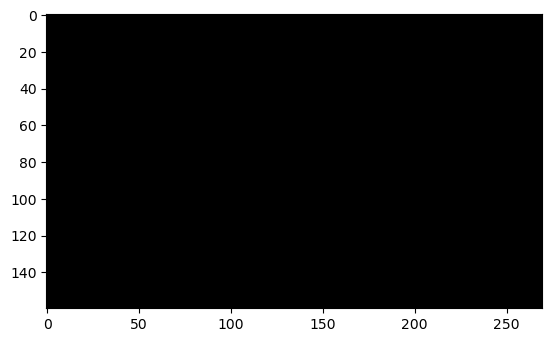

In [ ]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_NH.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 3, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "slow", show = True)

## Evaluation
Again, some evaluation on the different monster pools. The Knowledge Base tweaks brought an improvement in all of the three monster pools.

In [ ]:
ENV = gym.make("MiniHack-HideNSeek-Mapped-v0",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 500, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "fast", show = False)

#ADD GRAPH


In [ ]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_N.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 500, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "fast", show = False)

#ADD GRAPH
#REMOVE IMPOSSIBLE TO PERFORM ANY ACTION

In [ ]:
ENV = gym.make("MiniHack-Navigation-Custom-v0", des_file="dat/fully_observable_H.des",
              observation_keys=('screen_descriptions','message','pixel','blstats'))
evaluate(num_ep = 500, max_steps = 30, kb_path = 'kbs/project_kb.pl', env = ENV, speed = "fast", show = False)

#ADD GRAPH
#REMOVE IMPOSSIBLE TO PERFORM ANY ACTION